# Malaria Commodity Prediction
## Problem
The restocking of Malaria commodities is currently done based on 6 month averages computed by MoH officials from the KHIS system data. These averages do not paint a clear picture of trends related to consumption such as seasonality, increases or decreases as well as other confounding factors.

### We therefore embark on a solution to create a commodity demand prediction model based on time series

*-----------------------------------------------------------------------------------------------------------------------------*
## Import Required Libraries
*-----------------------------------------------------------------------------------------------------------------------------*
<br>
We would take necessary python libraries that we would use in Analyzing and creating our models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import timedelta,date

# Data Engineering & Analysis

## Describe and view the data set we have
We want the date column and the demand prediction. So we use pandas <b>read_csv</b> argument of 'usecols=<['col1','col2',...,'coln']>
<br>
We alson drop null values using pandas dropna()

We choose Nakuru as a model county to see how the performance of the model is before creating a python module that can be imported in order to do prediction for any county in the deployment stage.

In [3]:
#specify correct location of data as per now--- CSV file
dataframe=pd.read_csv('./Data/data.csv',usecols=['periodid','Nakuru County']).dropna()
#retieve 4 rows
dataframe.head(4)

,periodid,Nakuru County
0,2022-01,998
1,2022-02,1159
2,2022-03,1268
3,2022-04,909


Check for obvious metrics

In [5]:
dataframe.describe()

,Nakuru County
count,60.000000
mean,1093.316667
std,765.678905
min,151.000000
25%,612.250000
50%,934.000000
75%,1209.750000
max,3745.000000


In [7]:
dataframe.head(3)

,periodid,Nakuru County
0,2022-01,998
1,2022-02,1159
2,2022-03,1268


In [8]:
dataframe['periodid']=pd.to_datetime(dataframe['periodid'])
dset_indexed=dataframe.set_index(['periodid'])
dset_indexed.head(4)

,Nakuru County
periodid,
2022-01-01,998
2022-02-01,1159
2022-03-01,1268
2022-04-01,909


### Demand Trend of the period of 2018 to 2022 of Nakuru County
This clearly shows that the Demand for Malarial Commodities have been on average decline.

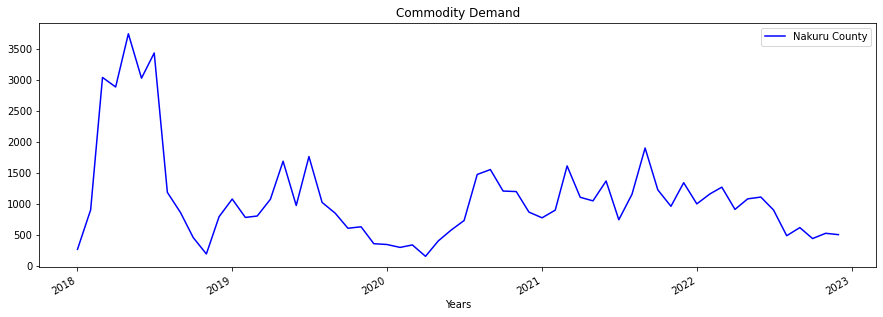

In [9]:
dset_indexed.plot(style='-', figsize=(15,5),color='blue',title='Commodity Demand')
plt.xlabel('Years')
plt.show()

## Train Test Split of the Data
We are not using random split since that would be very wrong instead do an assignment

In [10]:
#train data
#upper bound
train=dset_indexed.loc[dset_indexed.index<'01-01-2021']
#test data
#lower bound
test=dset_indexed.loc[dset_indexed.index>='01-01-2021']

We need to visualize this hence need for using matplot in order to see

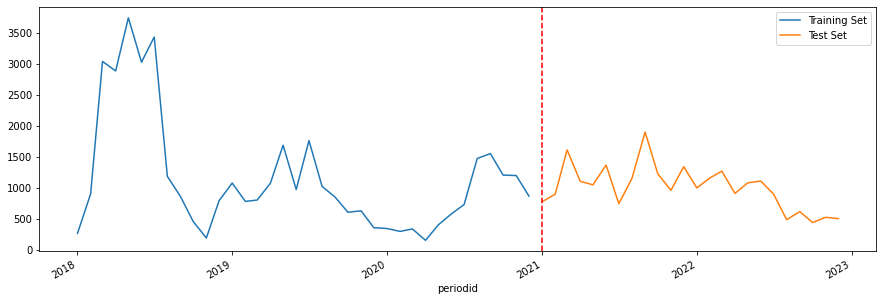

In [11]:
fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Train Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021',color='red',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

## Investigating Internal Trends
Investigating further to look for interesting insight

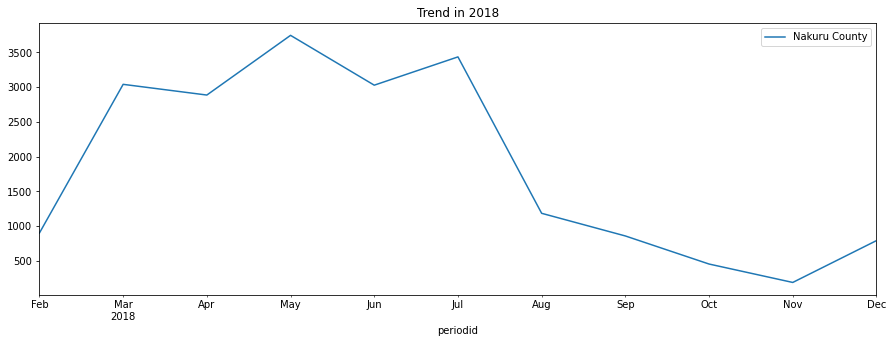

In [12]:
dset_indexed.loc[(dset_indexed.index>'01-01-2018')&(dset_indexed.index<'12-31-2018')].plot(figsize=(15,5), title='Trend in 2018')
plt.show()

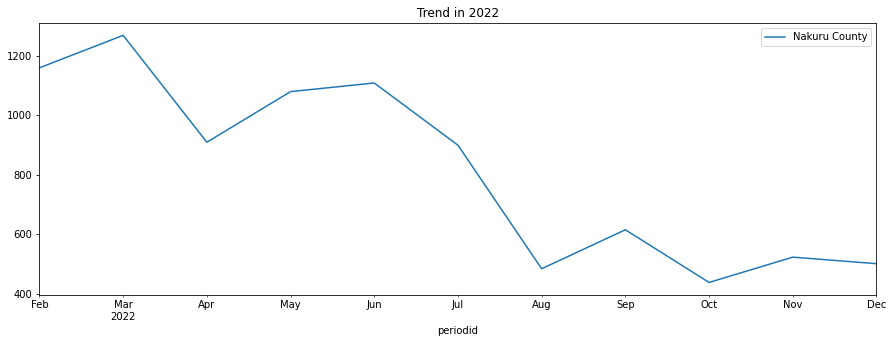

In [13]:
dset_indexed.loc[(dset_indexed.index>'01-01-2022')&(dset_indexed.index<'12-31-2022')].plot(figsize=(15,5), title='Trend in 2022')
plt.show()

## Generating Features
We generate our features using time series index, where it is provided by pandas

In [14]:

def feature_generator(dF):
    dF=dF.copy()
    dF['year']=dF.index.year#year
    dF['month']=dF.index.month #we get month from our datetime index
    
    return dF


In [15]:
df=feature_generator(dset_indexed)
df.head()


,Nakuru County,year,month
periodid,,,
2022-01-01,998,2022,1
2022-02-01,1159,2022,2
2022-03-01,1268,2022,3
2022-04-01,909,2022,4
2022-05-01,1079,2022,5


### Some of the basic discoveries with our new features
Let's use a box plot and see the distribution of the data frame

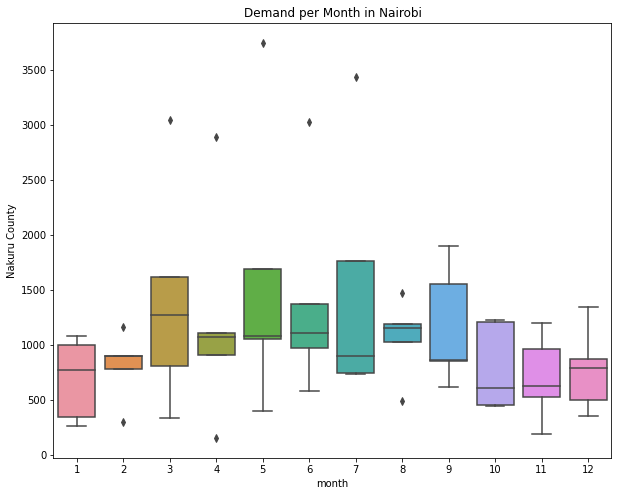

In [16]:
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='Nakuru County')
ax.set_title('Demand per Month in Nairobi')
plt.show()

# Model Development

In [17]:
#run train and test through features function to create features we are going to use
train_set=feature_generator(train)
test_set=feature_generator(test)


In [18]:
FEATURES=['year','month']
TARGET='Nakuru County'

In [19]:
X_train=train_set[FEATURES]
y_train=train_set[TARGET]

X_test=test_set[FEATURES]
y_test=test_set[TARGET]


In [20]:
#model
reg=xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

[0]	validation_0-rmse:1127.72919	validation_1-rmse:882.03079
[56]	validation_0-rmse:0.74666	validation_1-rmse:678.79583


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### How important are the features I have?
Let's look at some of the features generated and make a conclusion.

In [21]:
fimportance=pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_, columns=['Importance'])

This terms quater prediction as an inaccurate strategy for prediction of commodities. Meanwhile, the month features makes it to the spot light as of the highest importance.

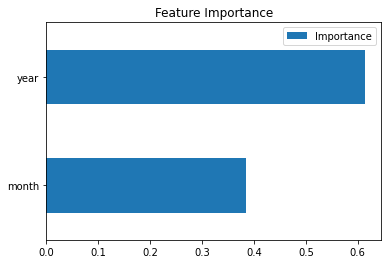

In [22]:
fimportance.sort_values('Importance').plot(kind='barh',title='Feature Importance')
plt.show()

## Making Predictions
Since the model has been established it is now important to do forecasting/ prediction.

In [23]:
test['prediction']=reg.predict(X_test)

C:\Users\theop\AppData\Local\Temp\ipykernel_10804\716901839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=reg.predict(X_test)


In [24]:
df=df.merge(test[['prediction']], how='left',left_index=True,right_index=True)
df.head()

,Nakuru County,year,month,prediction
periodid,,,,
2022-01-01,998,2022,1,281.291260
2022-02-01,1159,2022,2,281.291260
2022-03-01,1268,2022,3,281.291260
2022-04-01,909,2022,4,124.950447
2022-05-01,1079,2022,5,530.937439


### Show predictions on top of original data

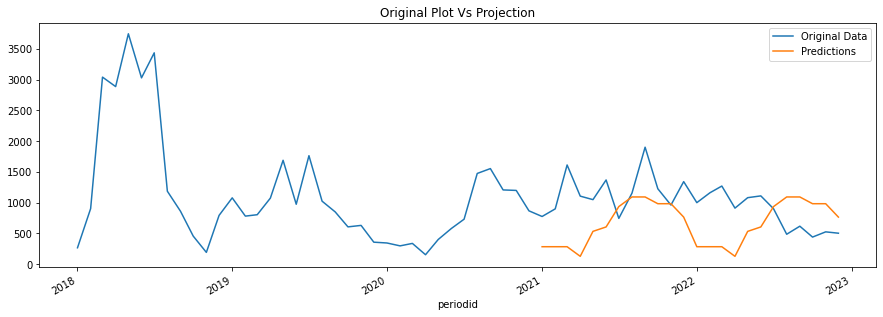

In [26]:
ax=df['Nakuru County'].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='-')
plt.legend(['Original Data','Predictions'])
ax.set_title('Original Plot Vs Projection')
plt.show()

### Now Look at the prediction with same trends that were intorduced

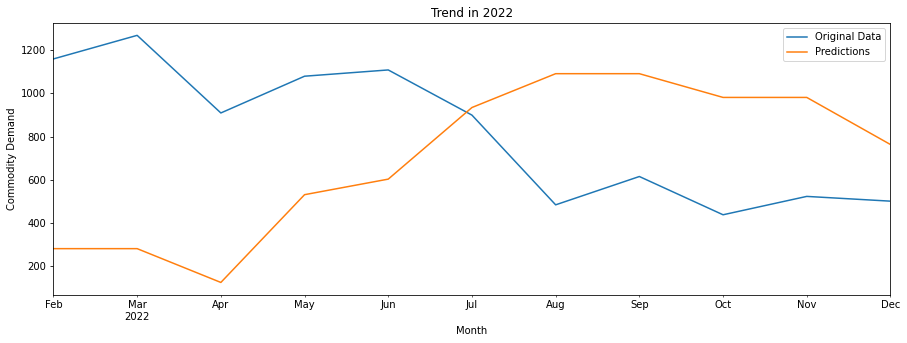

In [28]:
ax=df.loc[(df.index>'01-01-2022')&(df.index<'12-31-2022')]['Nakuru County']\
 .plot(figsize=(15,5), title='Trend in 2022')
df.loc[(df.index>'01-01-2022')&(df.index<'12-31-2022')]['prediction']\
    .plot(style='-')
plt.xlabel('Month')
plt.ylabel('Commodity Demand')
plt.legend(['Original Data','Predictions'])
plt.show()

## Evaluating and Getting the performance
We will use either RMSE or MSE

In [30]:
error=np.sqrt(mean_squared_error(test['Nakuru County'],test['prediction']))
print(f'Root Mean Squared Root: {error:.2f}')

Root Mean Squared Root: 641.69


Further experiments

In [31]:
starting_date='2022-01'
end_date='2022-05'

dates_array=[]
dates=pd.date_range(starting_date,end_date)
for date in dates:
    dates_array.append([date.year,date.month])
transf_dates_array=np.unique(dates_array,axis=0)

print(transf_dates_array)



#print(int(starting_date[5:]))

[[2022    1]
 [2022    2]
 [2022    3]
 [2022    4]
 [2022    5]]


In [32]:
date_input=pd.DataFrame(data=transf_dates_array,columns=['year','month'])
date_input
y_hat=reg.predict(date_input)
y_hat



array([281.29126, 281.29126, 281.29126, 124.95045, 530.93744],
      dtype=float32)

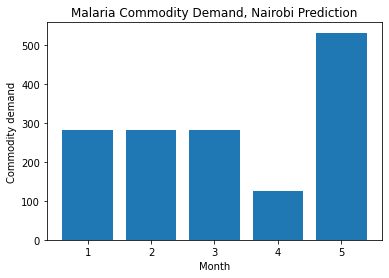

In [33]:
y_bar=y_hat
x_bar=transf_dates_array[:,1]
plt.xlabel('Month')
plt.ylabel('Commodity demand')
plt.title('Malaria Commodity Demand, Nairobi Prediction')
plt.bar(x_bar,y_bar)
plt.show()
